In [1]:
using Random, Distributions
using LinearAlgebra, Statistics
using CSV, DataFrames
using Plots

In [2]:
# Parameters to choose

γ = 0.2
β = 0.8 # 4% interest rate

ρ = 0.866
σ = 0.059
σ_0 = sqrt(σ^2/(1 - ρ^2)) # 0.12
m = 0.088


m_0 = 0.9
f = 30
c_e = 30

30

In [3]:
# Discretize AR(1) - Tauchen Method

function tauchen(m, σ, ρ=0.866, n_std = 10, N = 60)
    # Discretize space
    m_s = m/(1-ρ)
    σ_s = σ/sqrt(1-ρ^2)
    s_min = m_s - n_std * σ_s
    s_max = m_s + n_std * σ_s
    log_s = range(s_min, s_max, length = N)
    s = exp.(log_s)
    d = log_s[2] - log_s[1]
    d_half = d/2
    
    # Tranformation matrix
    P = zeros(N,N)
    for i in eachindex(log_s) 
        P[i,1] = cdf(Normal(0,1), (s_min + d_half -ρ*log_s[i]-m)/σ)
        P[i,N] = 1 - cdf(Normal(0,1), (s_max - d_half -ρ*log_s[i]-m)/σ)
        for j in 2:N-1
            P[i,j] = cdf(Normal(0,1), (log_s[j] + d_half -ρ*log_s[i]-m)/σ) - cdf(Normal(0,1), (log_s[j]  - d_half -ρ*log_s[i]-m)/σ)
        end    
    end
    return P,s
end

tauchen (generic function with 4 methods)

In [4]:
(P,s) = tauchen(m, σ)

([0.009620953413292282 0.03854482149708899 … 0.0 0.0; 0.0017064199217791704 0.010518957255237552 … 0.0 0.0; … ; 2.987065754920979e-290 1.2514963504770595e-279 … 0.01051895725523766 0.001706419921779112; 1.3040534759141209e-299 8.131841975583071e-289 … 0.03854482149708938 0.009620953413292277], [0.5926331201828956, 0.6168167657173304, 0.6419872759601613, 0.6681849220091137, 0.6954516183090697, 0.7238309897123167, 0.7533684412753334, 0.7841112309037793, 0.8161085449619172, 0.8494115769674374  …  4.378228836744466, 4.556891706993419, 4.74284529282528, 4.936387107280319, 5.13782680404647, 5.347486672884095, 5.565702155267583, 5.792822381068819, 6.029210727141131, 6.275245398697446])

In [5]:
# Find Value Function

function findV(p, V0, P, s, f=30, γ=0.2, β=0.8, max_it = 1e4, tol=1e-8)
    i = 1 
    dist = 1e3
    V = V0
    N = length(s)
    
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    while (i < max_it) & (dist > tol)
        V1 =  max.(0, profit + β * P'*V)
        dist = norm(V1 - V)
        V = V1
        i += 1
    end
    
    return V
    
end

findV (generic function with 6 methods)

In [6]:
function fr_entry(p, P, s, g, c_e=30)
    V0 = zeros(N)
    V = findV(p, V0, P, s)
    return  β*g'*V - c_e
end

fr_entry (generic function with 2 methods)

In [7]:
function eqm_price(P, s, g, max_it = 1e3, tol=1e-8)
    p_max = 100
    p_min = 0
    v_e = 1e3
    i = 0
    
    while (i < max_it) & (p_max - p_min > tol)
        p = (p_max + p_min)/2
        v_e = fr_entry(p, P, s, g)
        if v_e > 0
            p_max = p
        else
            p_min = p
        end
        i +=1
    end
    
    return p_min
end

eqm_price (generic function with 3 methods)

In [8]:
# Exit threshold

function exit_s(p, s, P, f=30)
    v = -1
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    V0 = zeros(N)
    V = profit + β*P'*findV(p, V0, P, s)
    
    return sum(V.<0)
end

exit_s (generic function with 2 methods)

In [9]:
# moments 

N = length(s)
    
    # Initial distribution
    G = cdf(LogNormal(m_0,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4)
    
price = eqm_price(P, s, g)   

# Exit rule
k = exit_s(price,s, P)
s_star = s[k+1]
    
    P_tilde = zeros(N,N)
    # g_tilde = zeros(N)
    for i in k+1:N
        P_tilde[i,:] = P[i,:]
        # g_tilde[i] = g[i]
    end
    



# Invariant distribution
μ=inv(I-P_tilde')*g
bar_μ =  μ/sum(μ)

α = zeros(5)
MU = zeros(5,N)

for i in eachindex(α)
    MU[i,:] = (P_tilde')^(i) * g
    α[i] = sum(MU[i,:])/sum(g)
end

In [10]:
df = DataFrame(CSV.File("/Users/yinyin/Documents/GitHub/Practice/firm_dynamics/bds2018_sector_fage.csv",delim=','))
d = filter([:year, :sector] => (year,sector) -> year==2018 && sector == "44-45" ,df)

firms = zeros(6)
firms[1] = d.firms[1]*5
firms[2] = sum(d.firms[2:6])
deaths = zeros(6)
deaths[1] =0
deaths[2] = sum(parse.(Int64, d.firmdeath_firms[2:6]))

for i in 3:6
    firms[i] = d.firms[4+i]
    deaths[i] = parse(Int64, d.firmdeath_firms[4+i])
end

# Survival rate in data

mom = zeros(5)
for i in 1:5
    mom[i] = (firms[i+1]-deaths[i+1])/firms[1]
end

In [11]:
# Survival rate in data

print("Survival rates in data:  ", mom)

Survival rates in data:  [0.5711072985254567, 0.38122507650932025, 0.31800055643141983, 0.2167022164518223, 0.18196234814059167]

In [12]:
# Survival rate in model

print("Survival rates in model:  ",α)

Survival rates in model:  [0.5783156631326258, 0.4243598111410076, 0.30408050591613317, 0.2129931909857645, 0.14658614254203206]

In [13]:
# Average firm age in data
sum(mom)*5

8.344987480293055

In [14]:
# Average firm age in model

sum(α)*5 

8.331676568587817

In [15]:
# Turnover rate in data: Entry/All firms i.e. λ/μ(S)
1/(sum(mom))

0.599162073257468

In [16]:
# Turnover rate in model: Entry/All firms i.e. λ/μ(S)
1/sum(α)

0.6001193107820649

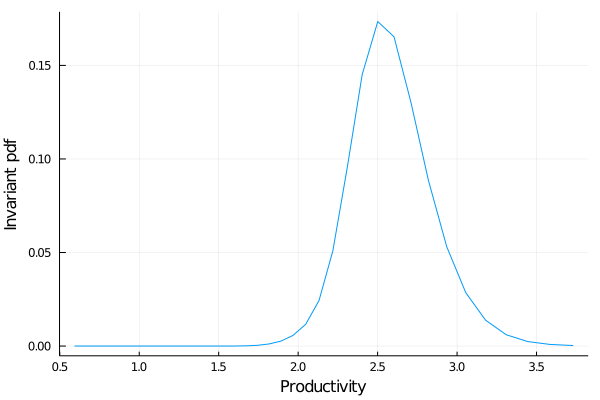

In [17]:
# Invariant distribution of productivity
plot1 = plot(s[1:47],bar_μ[1:47],legend = false)
xlabel!("Productivity")
ylabel!("Invariant pdf")
#savefig(plot1,"plot1.png")

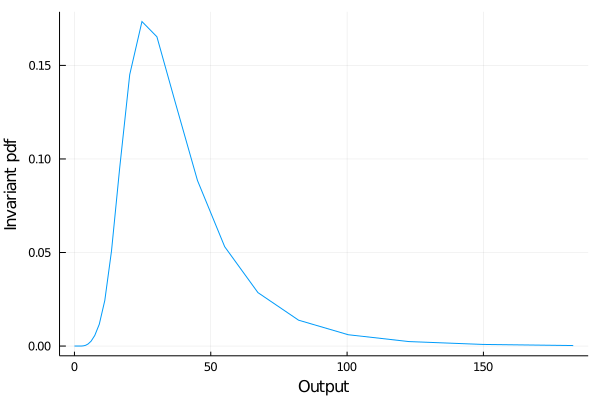

In [18]:
# Invariant distribution of firm size (in terms of output)

q = (price*s).^(1/γ)
plot2 = plot(q[1:47],bar_μ[1:47],legend = false,fmt = :png) 
xlabel!("Output")
ylabel!("Invariant pdf")
#savefig(plot2,"plot2.png")

In [19]:
k

36